# Eksperimen 4: OCR Pipeline (PaddleOCR + Qwen 2.5)

This notebook implements the full pipeline for Experiment 4 using PaddleOCR for text extraction and Qwen 2.5 (3B Instruct) for text correction/refinement.

**Key Improvements:**
- Robust Ollama response parsing.
- Incremental CSV saving to prevent data loss.
- Full dataset processing loop.


In [10]:
# Install required packages
%pip install ollama paddleocr opencv-python numpy pandas matplotlib seaborn

import os
import cv2
import matplotlib.pyplot as plt
import time
import glob
import numpy as np
import pandas as pd
import subprocess
from paddleocr import PaddleOCR

Note: you may need to restart the kernel to use updated packages.


### DATASET

In [11]:
DATASET_DIR = r'f:/projek dosen/tutoring/Agentic Multimodal Tutor - SLL/dataset/UTS/SOAL2'
IMAGES_DIR = DATASET_DIR
GT_DIR = DATASET_DIR

# ===================== LIMIT PROCESSING =====================
USE_LIMIT = True  # Set to True to limit the number of processed files
LIMIT_COUNT = 50   # Number of files to process if limit is active

### CER

In [12]:
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def calculate_cer(reference, hypothesis):
    if not reference:
        return 0.0
    ref = " ".join(reference.split())
    hyp = " ".join(hypothesis.split())
    return levenshtein_distance(ref, hyp) / len(ref)

### GROUND TRUTH

In [13]:
def read_ground_truth(filename_base):
    path = os.path.join(GT_DIR, f"{filename_base}.txt")
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            return f.read().strip()
    return ""

### OCR INIT

In [14]:
print("Initializing PaddleOCR...")
ocr = PaddleOCR(lang="en", enable_mkldnn=False, use_angle_cls=True)

C:\Users\User\AppData\Local\Temp\ipykernel_22892\2190322544.py:2: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(lang="en", enable_mkldnn=False, use_angle_cls=True)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\User\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.


Initializing PaddleOCR...


Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\User\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\User\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\User\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\User\.paddlex\official_models\en_PP-OCRv5_mobile_rec`.


### LLM CALL (AMAN)

In [15]:
# ===================== LLM CALL (ROBUST) =====================
def run_llm(prompt):
    # Run subprocess with robust encoding handling
    try:
        result = subprocess.run(
            ["ollama", "run", "qwen2.5:3b-instruct"],
            input=prompt,
            text=True,
            capture_output=True,
            encoding='utf-8',       # Ensure UTF-8 for I/O
            errors='replace'        # Replace chars that fail to encode/decode (fixes charmap error)
        )
        if result.returncode != 0:
            print(f"  [LLM ERROR] Exit Code: {result.returncode}")
            print(f"  [LLM STDERR] {result.stderr[:200]}...") # Print part of stderr
            return None
            
        return result.stdout.strip()
    except Exception as e:
        print(f"  [LLM EXCEPTION] {e}")
        return None


### FILE LIST

In [16]:
image_files = (
    glob.glob(os.path.join(IMAGES_DIR, "*.jpg")) +
    glob.glob(os.path.join(IMAGES_DIR, "*.png")) +
    glob.glob(os.path.join(IMAGES_DIR, "*.jpeg"))
)


results = []

# Apply Limit if Enabled
if USE_LIMIT and LIMIT_COUNT > 0:
    print(f"Limiting processing to first {LIMIT_COUNT} images.")
    image_files = image_files[:LIMIT_COUNT]

print(f"Found {len(image_files)} images.")


Limiting processing to first 50 images.
Found 50 images.


### MAIN LOOP

In [17]:
for idx, image_path in enumerate(image_files):
    filename = os.path.basename(image_path)
    filename_base = os.path.splitext(filename)[0]
    gt_text = read_ground_truth(filename_base)

    print(f"\nProcessing [{idx+1}/{len(image_files)}]: {filename}...")
    start_time = time.time()

    # ---------- OCR ----------
    ocr_result = ocr.predict(image_path)
    extracted_lines = []
    bboxes = []

    if ocr_result and len(ocr_result) > 0:
        if isinstance(ocr_result[0], dict) and "rec_texts" in ocr_result[0]:
            extracted_lines = ocr_result[0]["rec_texts"]
            if "dt_polys" in ocr_result[0]:
                bboxes = ocr_result[0]["dt_polys"]
        elif isinstance(ocr_result[0], list):
            for line in ocr_result[0]:
                if isinstance(line, list) and len(line) >= 2:
                    if isinstance(line[1], (tuple, list)):
                        extracted_lines.append(line[1][0])
                    if isinstance(line[0], list):
                        bboxes.append(line[0])

    raw_text = "\n".join(extracted_lines)

    # ---------- VISUALIZATION & BBOX ----------
    if bboxes:
        img_vis = cv2.imread(image_path)
        if img_vis is not None:
            img_vis = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)
            for box in bboxes:
                box = np.array(box).astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(img_vis, [box], True, (255, 0, 0), 2)
            
            # Save Image
            os.makedirs(r'results/bbox', exist_ok=True)
            vis_path = os.path.join(r'results/bbox', f'vis_{filename}')
            plt.figure(figsize=(10, 10))
            plt.imshow(img_vis)
            plt.axis('off')
            plt.savefig(vis_path, bbox_inches='tight')
            plt.close()
            
            # Save Coords TXT
            txt_path = os.path.join(r'results/bbox', f'bbox_{filename_base}.txt')
            with open(txt_path, 'w', encoding='utf-8') as f:
                for i, box in enumerate(bboxes):
                    text = extracted_lines[i] if i < len(extracted_lines) else ''
                    f.write(f'{box} | {text}\n')

    # ---------- LLM ----------
    final_text = raw_text

    if raw_text.strip():
        if not os.path.exists("prompt_correction.txt"):
            print("  [ERROR] prompt_correction.txt not found!")
            continue
        with open("prompt_correction.txt", "r", encoding="utf-8") as f:
            prompt = f.read().replace("{OCR_TEXT}", raw_text)

        print("  [LLM] running...")
        llm_out = run_llm(prompt)

        if llm_out is None:
            print("  [LLM] timeout → skip")
            final_text = raw_text
        else:
            final_text = (
                llm_out
                .replace("```plaintext", "")
                .replace("```", "")
                .strip()
            )
            print("  [LLM] done")

    # ---------- METRIC ----------
    elapsed = time.time() - start_time
    cer_raw = calculate_cer(gt_text, raw_text)
    cer_refined = calculate_cer(gt_text, final_text)

    print(
        f"  OCR Length: {len(raw_text)} | "
        f"CER Raw: {cer_raw:.2%} | "
        f"CER Refined: {cer_refined:.2%} | "
        f"Time: {elapsed:.2f}s"
    )

    results.append({
        "filename": filename,
        "time": elapsed,
        "cer_raw": cer_raw,
        "cer_refined": cer_refined,
        "raw_text": raw_text,
        "final_text": final_text,
        "ground_truth": gt_text
    })

    # Save partial results incrementally
    if len(results) > 0:
        pd.DataFrame(results).to_csv('results/exp4_results.csv', index=False)

print("\nDONE. Total processed:", len(results))


Processing [1/50]: if4908_103012400180_nomor2.jpg...
  [LLM] running...
  [LLM] done
  OCR Length: 218 | CER Raw: 30.77% | CER Refined: 33.48% | Time: 21.23s

Processing [2/50]: if4908_103012400221_nomor2.jpg...
  [LLM] running...
  [LLM] done
  OCR Length: 93 | CER Raw: 39.20% | CER Refined: 26.40% | Time: 16.87s

Processing [3/50]: if4908_103012400283_nomor2.jpg...
  [LLM] running...
  [LLM] done
  OCR Length: 119 | CER Raw: 0.00% | CER Refined: 0.00% | Time: 22.90s

Processing [4/50]: if4908_103012400355_nomor2.jpg...
  [LLM] running...
  [LLM] done
  OCR Length: 177 | CER Raw: 24.60% | CER Refined: 29.41% | Time: 22.83s

Processing [5/50]: if4908_103012400374_nomor2.jpg...
  [LLM] running...
  [LLM] done
  OCR Length: 90 | CER Raw: 38.66% | CER Refined: 40.34% | Time: 10.46s

Processing [6/50]: if4908_103012500007_nomor2.jpg...
  [LLM] running...
  [LLM] done
  OCR Length: 210 | CER Raw: 35.86% | CER Refined: 45.82% | Time: 22.10s

Processing [7/50]: if4908_1030125000185_nomor2.jp

Average Time: 17.9560s
Average CER (Raw): 36.46%
Average CER (Refined): 31.66%
Graph saved to results/cer_comparison.png


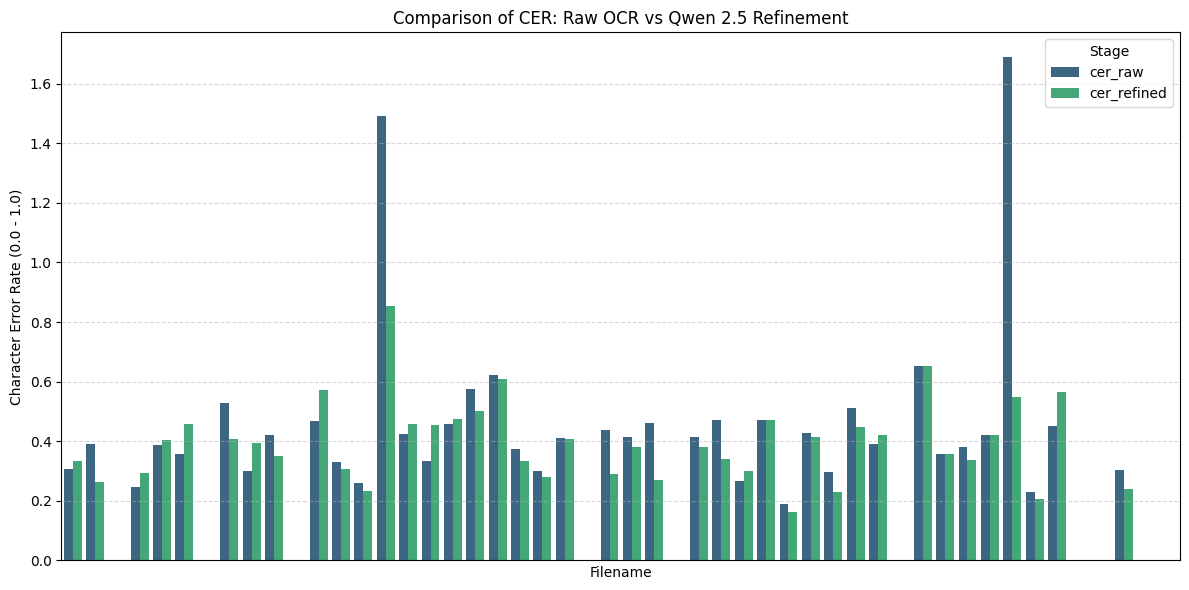

In [18]:
# ===================== VISUALIZE METRICS =====================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if results:
    df = pd.DataFrame(results)
    print(f"Average Time: {df['time'].mean():.4f}s")
    print(f"Average CER (Raw): {df['cer_raw'].mean():.2%}")
    print(f"Average CER (Refined): {df['cer_refined'].mean():.2%}")
    
    try:
        plt.figure(figsize=(12, 6))
        # Melt for seaborn
        df_melted = df.melt(id_vars=['filename'], value_vars=['cer_raw', 'cer_refined'], var_name='Stage', value_name='CER')
        
        sns.barplot(data=df_melted, x='filename', y='CER', hue='Stage', palette='viridis')
        plt.title('Comparison of CER: Raw OCR vs Qwen 2.5 Refinement')
        plt.xlabel('Filename')
        plt.ylabel('Character Error Rate (0.0 - 1.0)')
        # Too many x-labels might clutter, maybe strip?
        if len(df) > 20:
            plt.xticks([]) # Hide x labels if too many
        else:
            plt.xticks(rotation=45, ha='right')
            
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        
        save_path = 'results/cer_comparison.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Graph saved to {save_path}")
        plt.show()
    except Exception as e:
        print(f"Error plotting: {e}")
